In [1]:
# Hanya diperlukan untuk keperluan development
# import sys
# from google.colab import drive
# drive.mount('/content/drive/', force_remount=True)
# sys.path.append('/content/drive/My Drive/Colab Notebooks/EAS AB')


## Pustaka

In [2]:
from dataset import *
from IPython.display import display
import math
import pandas as pd
import random
import time

# Hanya diperlukan untuk keperluan development
# !pip install ortools
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

## Fungsi Bantuan

In [3]:
def get_distance(x, y, map):
  return map[x][y]

def total_distance(individu, map):
  distance = 0

  for idx in range(len(individu)):
    if idx == (len(individu)-1):
      break
    else:
      distance += get_distance( individu[idx], individu[idx+1], map)
  return distance

def slice_idx(dataset_length):
  idx = [random.randrange(dataset_length) for i in range(2)]
  return [min(idx), max(idx)]

def average_list(lst):
  return sum(lst) / len(lst)

def pdbest(best, bks):
  return ((best - bks)/bks)*100

def pdav(avg, bks):
  return ((avg - bks)/bks)*100

## Fungsi Populasi

In [4]:
def map_gen(dataset):
  w, h = len(dataset), len(dataset)
  map = [[0 for x in range(w)] for y in range(h)] 

  for i in range(len(dataset)):
    for j in range(len(dataset)):
      x1 = dataset[i][1]
      x2 = dataset[j][1]
      y1 = dataset[i][2]
      y2 = dataset[j][2]
      map[i][j] = round(math.sqrt(((x2-x1)**2) + ((y2-y1)**2)), 2)
    
  return map

def individu_gen(dataset_length):
  return random.sample( [i for i in range(dataset_length)], dataset_length )  

def population_gen(dataset_length, number_of_population):
  population = []
  for i in range(number_of_population):
    population.append(individu_gen(dataset_length))
  return population

## Fungsi Visualisasi

In [5]:
def map_as_table(map, **kwargs):
  df = pd.DataFrame(data=map)
  
  if "columns" in kwargs:
    df.columns = kwargs.get("columns")
  else:
    df.columns+=1

  if "index" in kwargs:
    df.index = kwargs.get("index")
  else:
    df.index+=1
  
  display(df)

def plot(title, **kwargs):
  index = ['eil51', 'berlin52', 'st70', 'eil76', 'rat99', 'kroA100', 'kroB100', 'kroC100', 'kroD100', 'kroE100', 'eil101', 'pr107', 'pr124', 'pr136', 'pr144']
  df = pd.DataFrame(kwargs,
                    index=index)
  
  ax = df.plot.bar(rot=0, figsize=(15, 15))
  ax.set_title(title)

## Fungsi Algoritma Genetika

In [6]:
def fitness(individu, map):
  distance = total_distance(individu, map)
  return ((1/distance), individu , distance)

def grade(population, map, fitness):
  graded = []
  for individu in population:
    graded.append(fitness(individu, map))
  return [i[1] for i in sorted(graded, reverse=True)]

def crossover(a, b):
  div_idx_1, div_idx_2 = slice_idx(len(a))
  slices = a[div_idx_1:div_idx_2]
  not_in_slices = [i for i in b if i not in slices]
  offspring = not_in_slices[0:div_idx_1] + slices + not_in_slices[div_idx_1:]
  return offspring

def mutate(individu, chance_to_mutate) :
  mutant = individu[:]
  r = random.random()
  first_idx = random.randint(0, len(individu)-1)
  second_idx = random.randint(0, len(individu)-1)
  if chance_to_mutate > r:
    mutant[first_idx],mutant[second_idx] = mutant[second_idx],mutant[first_idx]
  return mutant

def selection(population):
    return population[:2]
  

def genetic_algorithm(dataset):
  map = map_gen(dataset)

  NUMBER_OF_POPULATION = 50 
  NUMBER_OF_GENERATION = 1000
  CHANCE_TO_MUTATE = 1

  population = population_gen(len(dataset), NUMBER_OF_POPULATION)
  best_individu = None

  for generation in range(NUMBER_OF_GENERATION):
    graded_population = grade(population, map, fitness)[:49]

    grade_one, grade_two = selection(graded_population)

    best_individu = grade_one[:]
    
    child = crossover(grade_one, grade_two)
    mutant = mutate(child, CHANCE_TO_MUTATE)
    population = graded_population[:49]
    population.append(mutant)


  best_distance = total_distance(best_individu, map)
  return best_distance

## Fungsi Google OR-Tools

In [7]:
def create_data_model(map):
  data = {}
  data['distance_matrix'] = map
  data['num_vehicles'] = 1
  data['depot'] = 0
  return data

def or_tools(dataset):
  map = map_gen(dataset)
  data = create_data_model(map)

  manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                          data['num_vehicles'], data['depot'])

  routing = pywrapcp.RoutingModel(manager)

  distance_matrix = data['distance_matrix']

  def distance_callback(from_index, to_index):
    from_node = manager.IndexToNode(from_index)
    to_node = manager.IndexToNode(to_index)
    return distance_matrix[from_node][to_node]

  transit_callback_index = routing.RegisterTransitCallback(distance_callback)

  routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

  search_parameters = pywrapcp.DefaultRoutingSearchParameters()
  search_parameters.first_solution_strategy = (
      routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

  solution = routing.SolveWithParameters(search_parameters)

  best = solution.ObjectiveValue()
  return best

## Fungsi Benchmark

In [8]:
def bench(count, dataset, bks, method='ga'):
  best_pool = []
  if method == 'ga':
    func = genetic_algorithm
  elif method == 'or-tools':
    func = or_tools
  for i in range(count):
    best_pool.append(func(dataset))
  
  best = min(best_pool)
  avg = average_list(best_pool)

  dataset_pdbest = pdbest(best, bks)
  dataset_pdavg = pdav(avg, bks)
  return [bks, avg, best, dataset_pdavg, dataset_pdbest]

Current dataset: eil51
Current dataset: berlin52
Current dataset: st70
Current dataset: eil76
Current dataset: rat99
Current dataset: kroA100
Current dataset: kroB100
Current dataset: kroC100
Current dataset: kroD100
Current dataset: kroE100
Current dataset: eil101
Current dataset: pr107
Current dataset: pr124
Current dataset: pr136
Current dataset: pr144
Time elapsed: 2m 2s
Current dataset: eil51
Current dataset: berlin52
Current dataset: st70
Current dataset: eil76
Current dataset: rat99
Current dataset: kroA100
Current dataset: kroB100
Current dataset: kroC100
Current dataset: kroD100
Current dataset: kroE100
Current dataset: eil101
Current dataset: pr107
Current dataset: pr124
Current dataset: pr136
Current dataset: pr144
Time elapsed: 1m 1s


,Name,BKS,Average,Best,PDAv(%),PDBest(%)
1,eil51,426,778.892,707.17,82.838498,66.002347
2,berlin52,7542,13703.183,12646.11,81.691634,67.675815
3,st70,675,1782.446,1536.93,164.066074,127.693333
4,eil76,538,1320.765,1248.76,145.495353,132.111524
5,rat99,1211,4232.247,3997.02,249.483650,230.059455
6,kroA100,21282,82189.507,74483.15,286.192590,249.981910
7,kroB100,22140,84417.411,74954.91,281.289119,238.549729
8,kroC100,20749,83233.481,74922.16,301.144542,261.088052
9,kroD100,21294,82703.661,78413.35,288.389504,268.241523
10,kroE100,22068,85665.784,78372.86,288.190067,255.142559


,Name,BKS,Average,Best,PDAv(%),PDBest(%)
1,eil51,426,430.0,430,0.938967,0.938967
2,berlin52,7542,7924.0,7924,5.064970,5.064970
3,st70,675,663.0,663,-1.777778,-1.777778
4,eil76,538,537.0,537,-0.185874,-0.185874
5,rat99,1211,1240.0,1240,2.394715,2.394715
6,kroA100,21282,21923.0,21923,3.011935,3.011935
7,kroB100,22140,22892.0,22892,3.396567,3.396567
8,kroC100,20749,22198.0,22198,6.983469,6.983469
9,kroD100,21294,22392.0,22392,5.156382,5.156382
10,kroE100,22068,22479.0,22479,1.862425,1.862425


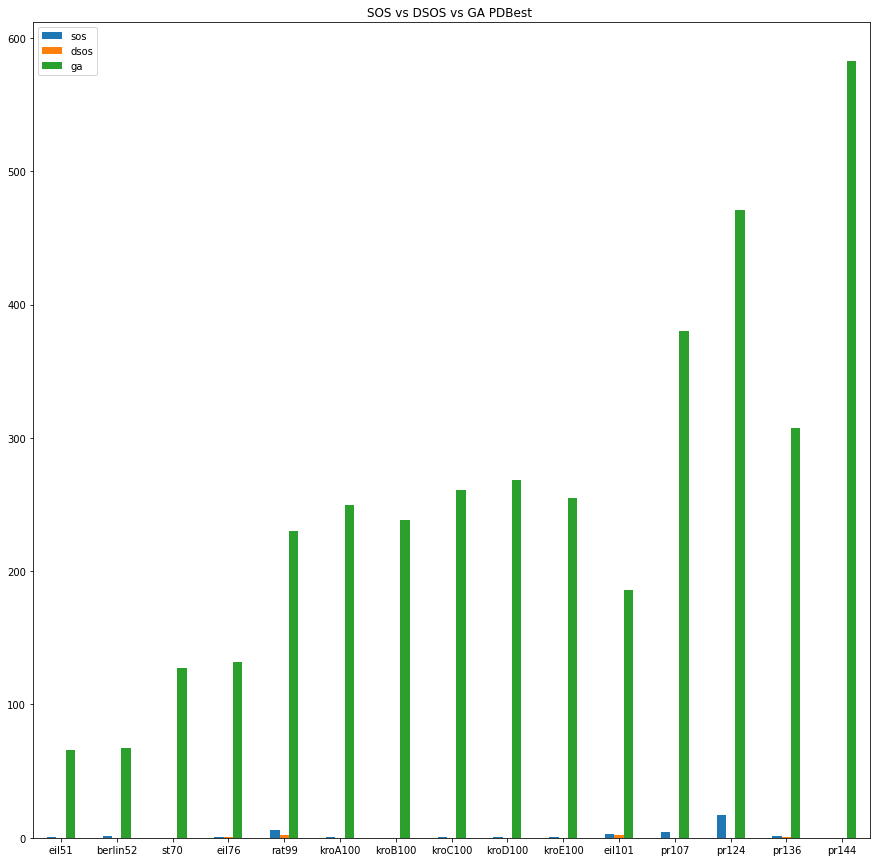

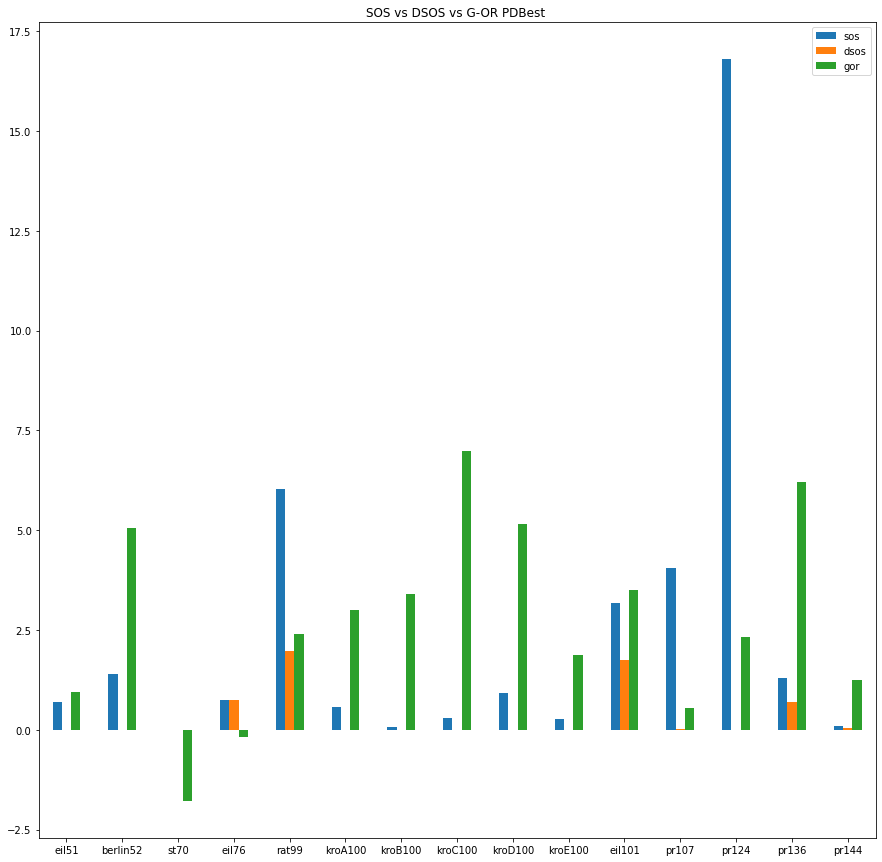

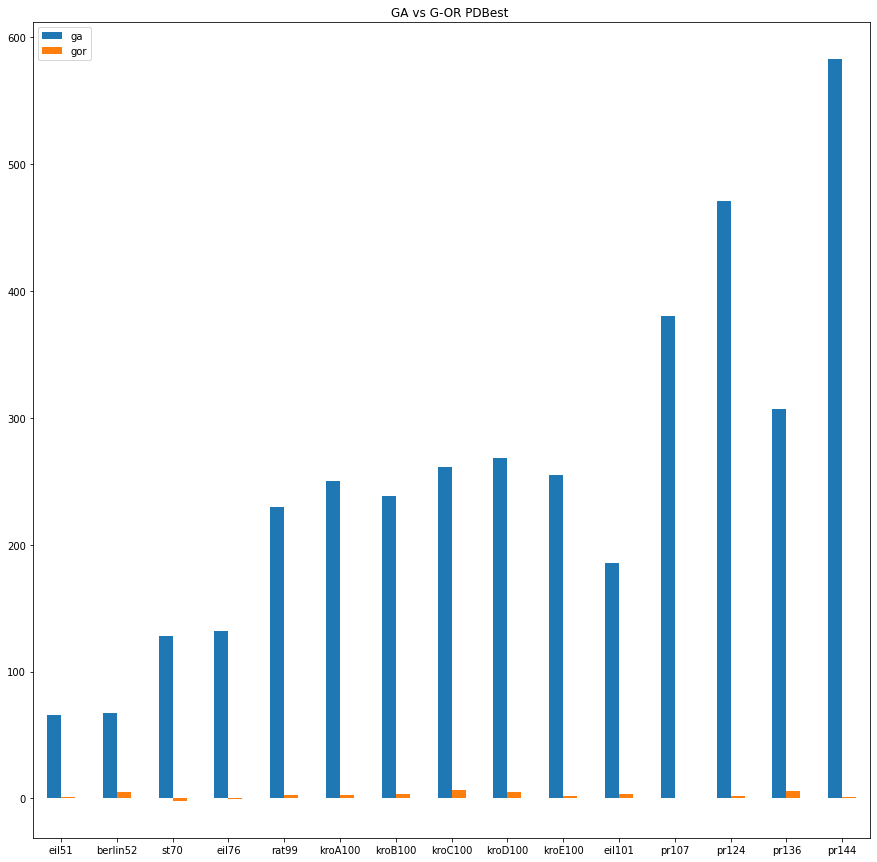

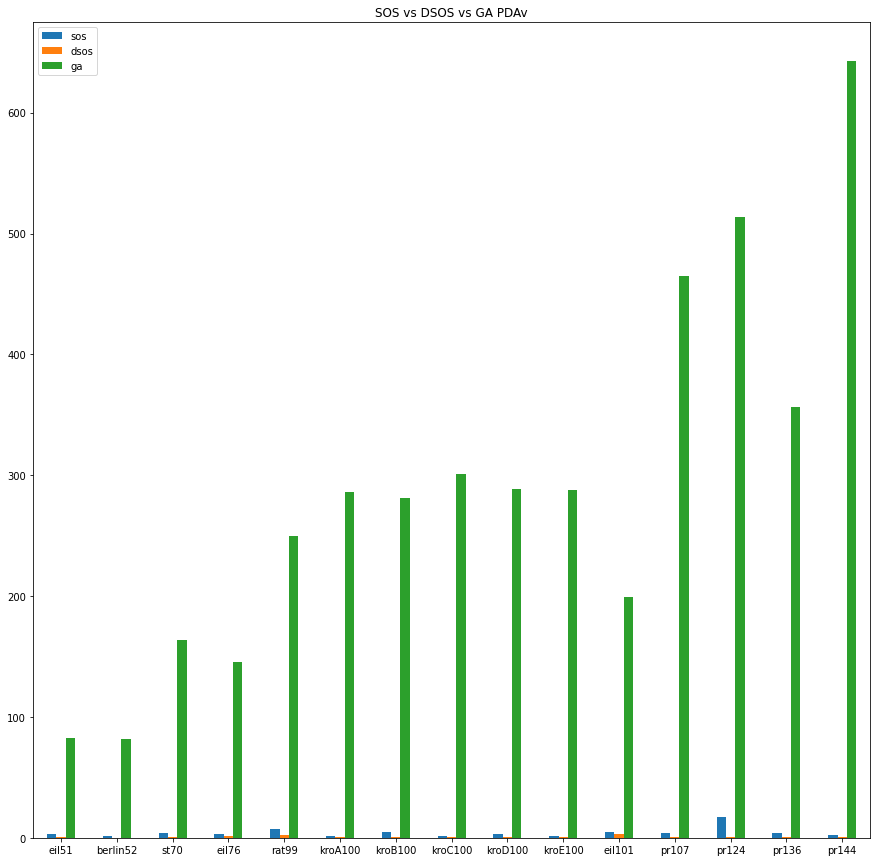

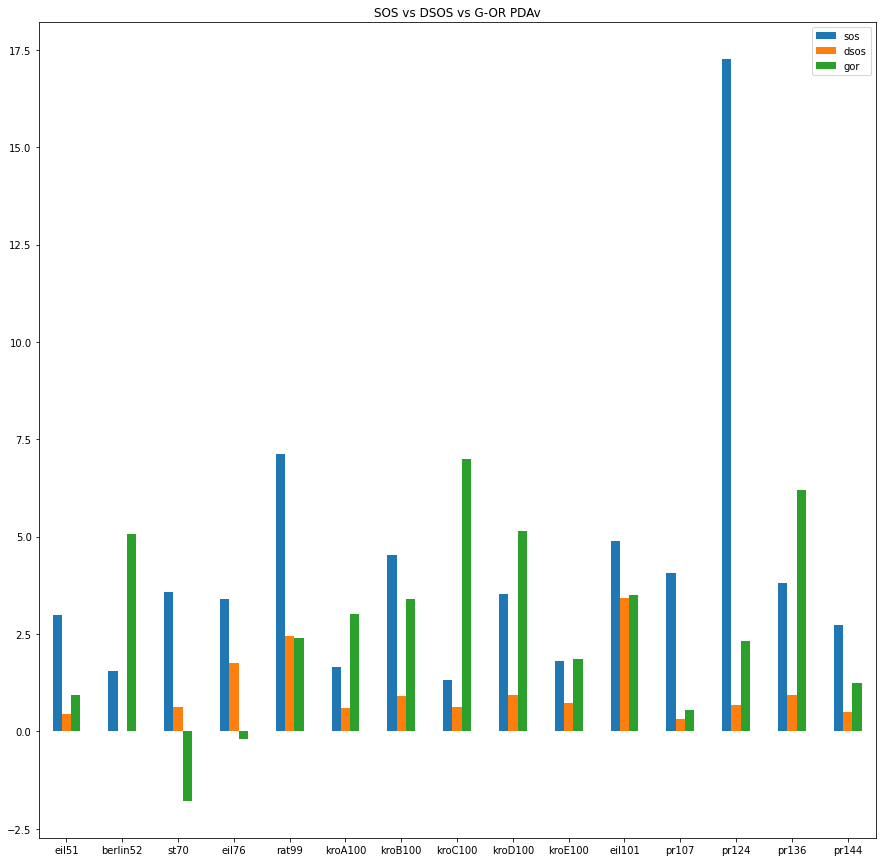

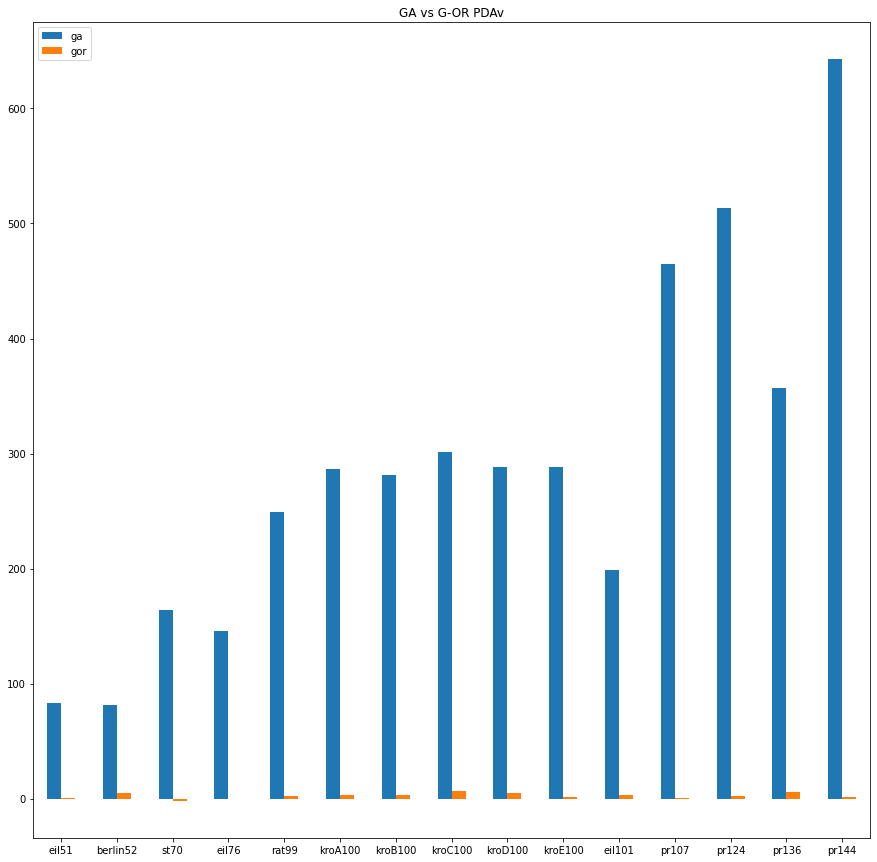

In [9]:
def main():
  BENCHMARK_ITERATION = 10
  sos_pdav = [ 2.99, 1.56, 3.57, 3.4, 7.13, 1.65, 4.529, 1.31, 3.52, 1.81, 4.88, 4.08, 17.25, 3.81, 2.73 ]
  sos_pdbest = [0.7, 1.39, 0, 0.74, 6.03, 0.56, 0.07, 0.3, 0.93, 0.27, 3.18, 4.05, 16.79, 1.29, 0.09]
  dsos_pdav = [ 0.45, 0.01, 0.62, 1.75, 2.46, 0.60, 0.90, 0.64, 0.94, 0.74, 3.43, 0.32, 0.68, 0.93, 0.49]
  dsos_pdbest = [0, 0, 0, 0.74, 1.98, 0, 0, 0, 0, 0, 1.75, 0.02, 0, 0.69, 0.05]

  # Genetic Algorithm
  ga_results = []
  ga_pdbest = []
  ga_pdav = []
  start = time.time()
  for dataset in dataset_list:
    print(f'Current dataset: {dataset[2]}')
    benchmark = bench(BENCHMARK_ITERATION, dataset[0], dataset[1], 'ga')
    benchmark.insert(0,dataset[2])
    ga_pdbest.append(benchmark[5])
    ga_pdav.append(benchmark[4])
    ga_results.append(benchmark)
  end = time.time()
  total_t = time.gmtime((end - start))
  print (f'Time elapsed: {total_t.tm_min}m {total_t.tm_min}s')


  # Google OR-Tools
  gor_results = []
  gor_pdbest = []
  gor_pdav = []
  start = time.time()
  for dataset in dataset_list:
    print(f'Current dataset: {dataset[2]}')
    benchmark = bench(BENCHMARK_ITERATION, dataset[0], dataset[1], 'or-tools')
    benchmark.insert(0,dataset[2])
    gor_pdbest.append(benchmark[5])
    gor_pdav.append(benchmark[4])
    gor_results.append(benchmark)
  end = time.time()
  total_t = time.gmtime((end - start))
  print (f'Time elapsed: {total_t.tm_min}m {total_t.tm_min}s')
  


  map_as_table(ga_results, columns=['Name', 'BKS', 'Average', 'Best', 'PDAv(%)', 'PDBest(%)'])
  map_as_table(gor_results, columns=['Name', 'BKS', 'Average', 'Best', 'PDAv(%)', 'PDBest(%)'])
  
  plot("SOS vs DSOS vs GA PDBest ", sos=sos_pdbest, dsos=dsos_pdbest, ga=ga_pdbest)
  plot("SOS vs DSOS vs G-OR PDBest ", sos=sos_pdbest, dsos=dsos_pdbest, gor=gor_pdbest)
  plot("GA vs G-OR PDBest ", ga=ga_pdbest, gor=gor_pdbest)
  
  plot("SOS vs DSOS vs GA PDAv", sos=sos_pdav, dsos=dsos_pdav, ga=ga_pdav)
  plot("SOS vs DSOS vs G-OR PDAv", sos=sos_pdav, dsos=dsos_pdav, gor=gor_pdav)
  plot("GA vs G-OR PDAv", ga=ga_pdav, gor=gor_pdav)

main()